# **RAG pipeline evaluation using UpTrain**

[UpTrain](https://uptrain.ai/) is an evaluation framework that provides a number of LLM-based evaluation metrics and can be used to evaluate [Retrieval Augmented Generation](https://www.deepset.ai/blog/llms-retrieval-augmentation) (RAG) pipelines.
It supports metrics like context relevance, factual accuracy, guideline adherence and more.

For more information about evaluators, supported metrics and usage, check out:

* [UpTrainEvaluator](https://docs.haystack.deepset.ai/docs/uptrainevaluator)
* [Model based evaluation](https://docs.haystack.deepset.ai/docs/model-based-evaluation)

This notebook shows how to use the [UpTrain-Haystack](https://haystack.deepset.ai/integrations/uptrain) integration to evaluate a RAG pipeline against various metrics.

Notebook by [*Anushree Bannadabhavi*](https://github.com/AnushreeBannadabhavi)

## Prerequisites:

- API key
    - We need an API key to run evaluations with **UpTrain**. To see a list of the LLMs supported by UpTrain refer to this [page](https://docs.uptrain.ai/llms/openai).
    - This notebook uses OpenAI for the evaluation pipeline.

## Install dependencies

In [ ]:
%%bash

pip install "pydantic<1.10.10"
pip install haystack-ai
pip install "datasets>=2.6.1"
pip install uptrain-haystack

## Create a RAG pipeline

We'll first need to create a RAG pipeline. Refer to this [link](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) for a detailed tutorial on how to create RAG pipelines.

In this notebook, we're using the [SQUAD V2](https://huggingface.co/datasets/rajpurkar/squad_v2) dataset for getting the context, questions and ground truth answers.





**Initialize the document store**

In [98]:
from datasets import load_dataset
from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

dataset = load_dataset("rajpurkar/squad_v2", split="validation")
documents = list(set(dataset["context"]))
docs = [Document(content=doc) for doc in documents]
document_store.write_documents(docs)

1204

In [99]:
import os
from getpass import getpass
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store, top_k=3)

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18")

Enter OpenAI API key:··········


**Build the RAG pipeline**

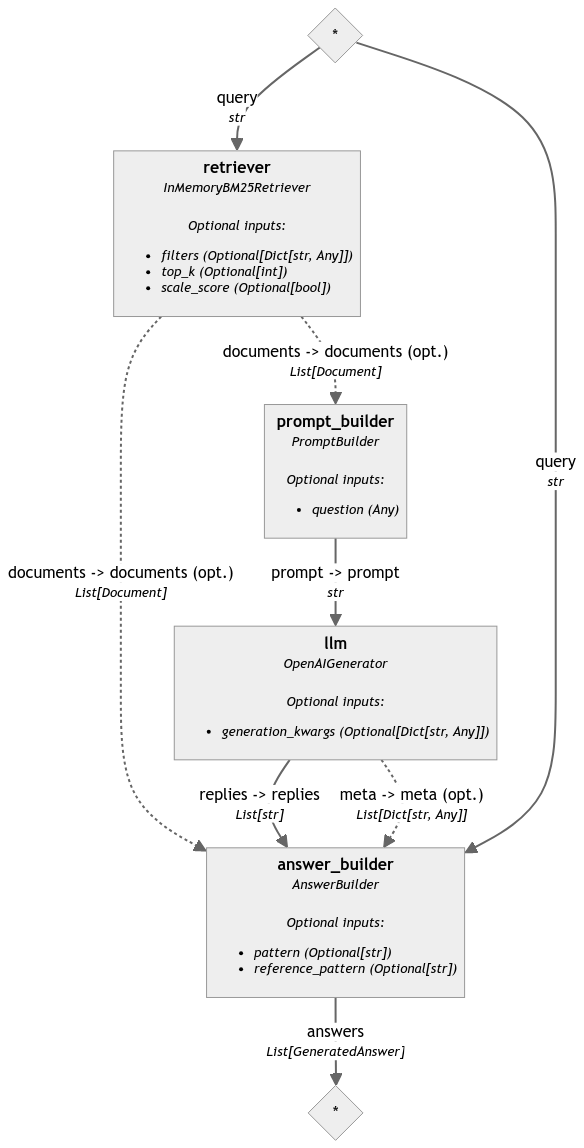

In [100]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("llm.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")


**Running the pipeline**

In [101]:
question = "In what country is Normandy located?"

response = rag_pipeline.run(
    {"retriever": {"query": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}}
)


Ranking by BM25...:   0%|          | 0/1204 [00:00<?, ? docs/s]

In [102]:
print(response["answer_builder"]["answers"][0].data)

Normandy is located in France.


We're done building our RAG pipeline. Let's evaluate it now!

## Get questions, contexts, responses and ground truths for evaluation

For computing most metrics, we will need to provide the following to the evaluator:
1. Questions
2. Generated responses
3. Retrieved contexts
4. Ground truth

Below is a helper function to get `contexts` and `responses`.

### Helper function to get context and responses


In [103]:
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "retriever": {"query": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses


In [ ]:
question_map = {
    "Which mountain range influenced the split of the regions?": 0,
    "What is the prize offered for finding a solution to P=NP?": 1,
    "Which Californio is located in the upper part?": 2
}
questions = list(question_map.keys())
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)

### Get ground truths

Since we're using the SQUAD dataset, ground truth answers are also available.

In [105]:
ground_truths = [""] * len(question_map)

for question, index in question_map.items():
    idx = dataset["question"].index(question)
    ground_truths[index] = dataset["answers"][idx]["text"][0]

In [106]:
print("Questions\n")
print("\n".join(questions))

Questions

Which mountain range influenced the split of the regions?
What is the prize offered for finding a solution to P=NP?
Which Californio is located in the upper part?


In [107]:
print("Responses\n")
print("\n".join(responses))

Responses

The Tehachapi mountains influenced the split of the regions as mentioned in the passage.
The prize offered for finding a solution to P=NP is US$1,000,000.
The Californio located in the upper part is the Upper Rhine.


In [108]:
print("Ground truths\n")
print("\n".join(ground_truths))

Ground truths

Tehachapis
$1,000,000
Monterey


## Evaluate the RAG pipeline

Now that we have the `questions`, `generated answers`, `contexts` and the `ground truths`, we can begin our pipeline evaluation and compute all the supported metrics.

## UpTrainEvaluator

We can use the `UpTrainEvaluator` component to evaluate our Pipeline against one of the metrics provided by UpTrain.

The evaluation pipeline follows a simple structure:
1. Create the pipeline object.
2. Instantiate the evaluator object with the following parameters:
    - `metric`: The upTrain metric you want to compute
    - `metric_params`: Any additional parameters that that is required for the metric computation
    - `api`: The API you want to use with your evaluator
    - `api_key`: By default, this component looks for an environment variable called `OPENAI_API_KEY`. To change this, pass `Secret.from_env_var("YOUR_ENV_VAR")` to this parameter.
3. Add the evaluator component to the pipeline.
    - Note: We can add multiple evaluator components to the pipeline and compute multiple metrics. Example present [here](#scrollTo=K0GMm1blcOkZ).
4. Run the evaluation pipeline with the necessary inputs.


```
# Create the pipeline object
eval_pipeline = Pipeline()

# Initialize the evaluator object
evaluator = UpTrainEvaluator(metric=UpTrainMetric.{METRIC_NAME})

# Add the evaluator component to the pipeline
eval_pipeline.add_component("evaluator", evaluator)

# Run the evaluation pipeline with the necessary inputs
evaluation_results = eval_pipeline.run(
    {"evaluator": {"contexts": contexts, "responses": responses}}
)
```



## Metrics computation

For a full list of available metrics and their expected inputs, check out the [UpTrainEvaluator Docs](https://docs.haystack.deepset.ai/docs/uptrainevaluator).
Additionally, UpTrain offers score explanations which can be quite useful.

[UpTrain Docs](https://docs.uptrain.ai/) also offers explanations of all metrics along with simple examples.

### Helper function to print results

Below is a helper function to print the results of our evaluation pipeline

In [109]:
def print_results(questions: list, results: dict):
  for index, question in enumerate(questions):
    print(question)
    result_dict = results['results'][index][0]
    for key, value in result_dict.items():
      print(f"{key} : {value}")
    print("\n")

### **Context relevance**

Measures how relevant the context was to the question specified.

In [110]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.CONTEXT_RELEVANCE,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)


In [111]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "contexts": contexts}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:04:08.769 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:04:21.216 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:04:33.232 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : context_relevance
score : 0.0
explanation :  "The extracted context primarily focuses on the geographical and climatic aspects of California, Victoria, and orogenic wedges, and does not provide any information related to the influence of mountain ranges on the split of regions. Therefore, the given user query cannot be answered at all with the extracted context."



What is the prize offered for finding a solution to P=NP?
name : context_relevance
score : 1.0
explanation : ['The extracted context can answer the given user query completely. It explicitly states that there is a US$1,000,000 prize for resolving the P versus NP problem, providing a clear and specific answer to the user query.']


Which Californio is located in the upper part?
name : context_relevance
score : 0.0
explanation : ["The extracted context is focused on the geography of the Rhine river, the Roman frontier, and plate tectonics. There is no mention 

### **Factual accurracy**

Factual accuracy score measures the degree to which a claim made in the response is true according to the context provided.

In [112]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.FACTUAL_ACCURACY,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [113]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:04:48.945 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:04:57.366 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:05:03.061 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : factual_accuracy
score : 1.0
explanation : The Tehachapi mountains influenced the split of the regions.
Reasoning for yes: The context explicitly mentions the geographical phrase "South of the Tehachapis, which would split the southern region off at the crest of that transverse range," indicating that the Tehachapi mountains influenced the split of the regions.
Reasoning for no: No arguments.
Judgement: yes. as the context explicitly supports the fact.


What is the prize offered for finding a solution to P=NP?
name : factual_accuracy
score : 1.0
explanation : The prize offered for finding a solution to P=NP is US$1,000,000.
Reasoning for yes: The context explicitly states that there is a US$1,000,000 prize for resolving the P versus NP problem.
Reasoning for no: No arguments.
Judgement: yes. as the context explicitly supports the fact.


Which Californio is located in the upper part?
name : factual_accuracy
score : 1.0

## **Response relevance**

Response relevance is the measure of how relevant the generated response is to the question asked.

In [114]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_RELEVANCE,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [115]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:05:11.662 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:05:24.507 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:05:39.232 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : response_relevance
score : 0.33333333333333337
explanation : The LLM response directly addresses the user query by providing the specific mountain range, Tehachapi mountains, which influenced the split of the regions. This information is critical as it directly answers the user query and provides the necessary detail to understand the geographical influence on the region split.
The LLM response only provides the name of the mountain range (Tehachapi mountains) but does not explain how it influenced the split of the regions. Without the explanation, the response does not provide a complete answer to the user query.


What is the prize offered for finding a solution to P=NP?
name : response_relevance
score : 0.9473684210526316
explanation : The user query specifically asks for the prize offered for finding a solution to P=NP. The LLM response provides exactly that information, stating the prize amount as US$1,000,000. The

### **Response completeness**

Response completeness score measures if the generated response has adequately answered all aspects to the question being asked.

In [116]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_COMPLETENESS,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [117]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:05:55.620 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:06:08.180 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:06:15.882 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : response_completeness
score : 0.3
explanation : The response partially answers the user query by providing the name of the mountain range that influenced the split of the regions. However, it does not provide the specific details of how the Tehachapi mountains influenced the split of the regions, which is necessary for a comprehensive answer.


What is the prize offered for finding a solution to P=NP?
name : response_completeness
score : 0.9
explanation : {
"User query summary": "What is the prize offered for finding a solution to P=NP?",
"Reasoning to determine clarity of the user query": The user query is clear and straightforward.
"Is the user query clear": Yes,
"Information required in an ideal response": Prize amount for finding a solution to P=NP,
"Portions of Information in an ideal response which are covered in the response": The LLM response covers the prize amount for finding a solution to P=NP.
"Portions of I

### **Response completeness with respect to context**

Measures how complete the generated response was for the question specified given the information provided in the context.

In [118]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_COMPLETENESS_WRT_CONTEXT,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [119]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:06:23.587 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:06:27.682 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:06:33.977 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : response_completeness_wrt_context
score : 1.0
explanation : Key points present in the context relevant to the given question:
1. The geographical phrase "South of the Tehachapis" influenced the split of the southern region.
2. The desert portions of north Los Angeles County and eastern Kern and San Bernardino Counties would be included in the southern California region due to their remoteness from the central valley and interior desert landscape.

Key points present in the response relevant to the given question:
1. The Tehachapi mountains influenced the split of the regions.

Reasoning:
The context clearly mentions the influence of the geographical phrase "South of the Tehachapis" in splitting the southern region, along with the inclusion of desert portions in the southern California region. The response accurately identifies the Tehachapi mountains as the influence for the split of the regions.

[Choice]: (A) The gene

### **Response consistency**

Response Consistency is the measure of how well the generated response aligns with both the question asked and the context provided.

In [120]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_CONSISTENCY,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [121]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:06:38.957 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:06:49.394 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:02.111 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : response_consistency
score : 0.9
explanation : The argument is logical and well-supported by the information in the context. The response directly addresses the specific mountain range mentioned in the context as influencing the split of the regions.


What is the prize offered for finding a solution to P=NP?
name : response_consistency
score : 1.0
explanation : The argument is logical and well-supported by the information in the context. The response directly provides the prize amount mentioned in the context, leaving no room for ambiguity or misinterpretation.


Which Californio is located in the upper part?
name : response_consistency
score : 0.9
explanation : The argument is logical and well-supported by the information in the context. The response directly addresses the question and aligns with the information provided in the context regarding the Upper Rhine.




### **Response conciseness**

Response conciseness score measures whether the generated response contains any additional information irrelevant to the question asked.

In [122]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_CONCISENESS,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [123]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:07:12.613 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:20.135 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:29.139 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : response_conciseness
score : 1.0
explanation : The LLM response directly addresses the user query by providing the specific mountain range, Tehachapi mountains, which influenced the split of the regions. This information is crucial as it directly answers the user query and provides the necessary detail to understand the geographical influence on the region split.


What is the prize offered for finding a solution to P=NP?
name : response_conciseness
score : 1.0
explanation : The LLM response directly addresses the user query by providing the specific prize amount offered for finding a solution to P=NP. There is no irrelevant information present in the response, as the prize amount is the key information sought by the user.


Which Californio is located in the upper part?
name : response_conciseness
score : 0.8
explanation : The LLM response directly addresses the user query by providing the specific Californio located i

### **Critique language**

Evaluates the response on multiple aspects - fluency, politeness, grammar, and coherence. It provides a score for each of the aspects on a scale of 0 to 1, along with an explanation for the score.

In [124]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.CRITIQUE_LANGUAGE,
    api="openai",
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [125]:
results = evaluator_pipeline.run({"evaluator": {"responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:07:35.724 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:37.319 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:38.993 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : fluency
score : 1.0
explanation : The text is fluent and natural sounding.


What is the prize offered for finding a solution to P=NP?
name : fluency
score : 1.0
explanation : The text is very fluent and natural sounding, with no awkward phrasing.


Which Californio is located in the upper part?
name : fluency
score : 0.2
explanation : The text is not fluent at all and has awkward phrasing.




### **Critique tone**

Evaluates the tone of machine generated responses. Provide your required tone as an additional paramter. Example: `metric_params={"llm_persona": "informative"}`

In [126]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.CRITIQUE_TONE,
    api="openai",
    metric_params={"llm_persona": "informative"}
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [127]:
results = evaluator_pipeline.run({"evaluator": {"responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:07:42.266 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:43.868 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:46.946 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : tone
score : 1.0
explanation : The response is informative and directly addresses the topic at hand. It aligns well with the specified persona of being informative. 
[Score]: 5


What is the prize offered for finding a solution to P=NP?
name : tone
score : 1.0
explanation : [Persona]: informative
[Response]: The prize offered for finding a solution to P=NP is US$1,000,000.
[Reasoning]: The response is straightforward and provides factual information, which aligns with the informative persona. It effectively delivers the information without any unnecessary details or opinions.
[Score]: 5


Which Californio is located in the upper part?
name : tone
score : 1.0
explanation : The response is informative and provides a clear statement. It matches the specified persona of being informative. 
[Score]: 5




### **Guideline adherence**

Evaluates how well the LLM adheres to a provided guideline when giving a response.

In [128]:
import os
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

evaluator = UpTrainEvaluator(
    metric=UpTrainMetric.GUIDELINE_ADHERENCE,
    api="openai",
    metric_params={"guideline": "Response shouldn't contain any personal information.",
                   "guideline_name": "personal info check"}
)

evaluator_pipeline = Pipeline()
evaluator_pipeline.add_component("evaluator", evaluator)

In [129]:
results = evaluator_pipeline.run({"evaluator": {"questions": questions, "responses": responses}})
print("\n")
print_results(questions, results["evaluator"])

2024-03-23 23:07:49.209 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:07:57.936 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:04.632 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain




Which mountain range influenced the split of the regions?
name : personal info check_adherence
score : 1.0
explanation : The given LLM response strictly adheres to the guideline because it does not contain any personal information. The response only focuses on the influence of the Tehachapi mountains on the split of the regions, without including any personal details. Therefore, it aligns with the guideline of not including personal information.


What is the prize offered for finding a solution to P=NP?
name : personal info check_adherence
score : 1.0
explanation :  "The given LLM response strictly adheres to the guideline as it does not contain any personal information. The response only provides information about the prize offered for finding a solution to P=NP, which is a general and non-personal piece of information. Therefore, the LLM response strictly adheres to the guideline by not including any personal information."



Which Californio is located in the upper part?
name : p

## **Add multiple evaluator components in a single pipeline**

In the code above, we created separate `pipeline` objects for every `metric`. Instead, we can also create a single `pipeline` object and add all the evaluators as components.

The final result will then include all the metrics.

In [130]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.uptrain import UpTrainEvaluator, UpTrainMetric

pipeline = Pipeline()
evaluator_response_consistency = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_CONSISTENCY,
)
evaluator_response_completeness = UpTrainEvaluator(
    metric=UpTrainMetric.RESPONSE_COMPLETENESS,
)
pipeline.add_component("evaluator_response_consistency", evaluator_response_consistency)
pipeline.add_component("evaluator_response_completeness", evaluator_response_completeness)


In [131]:
results = pipeline.run({
        "evaluator_response_consistency": {"questions": questions, "contexts": contexts, "responses": responses},
        "evaluator_response_completeness": {"questions": questions, "responses": responses},
})

2024-03-23 23:08:11.279 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:22.700 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:33.911 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:45.029 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:51.844 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain
2024-03-23 23:08:59.642 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain


In [132]:
print_results(questions, results["evaluator_response_consistency"])

Which mountain range influenced the split of the regions?
name : response_consistency
score : 1.0
explanation : The argument is logical and well-supported by the information in the context. The response directly addresses the question by providing the specific mountain range mentioned in the context.


What is the prize offered for finding a solution to P=NP?
name : response_consistency
score : 1.0
explanation : The argument is logical and well-supported by the information in the context. The response directly provides the specific prize amount offered for finding a solution to P=NP, which is consistent with the information provided in the context.


Which Californio is located in the upper part?
name : response_consistency
score : 0.9
explanation : The argument is logical and well-supported by the information in the context. The response directly addresses the question and aligns with the information provided in the context.




In [133]:
print_results(questions, results["evaluator_response_completeness"])

Which mountain range influenced the split of the regions?
name : response_completeness
score : 0.8
explanation : {
"User query summary": "Which mountain range influenced the split of the regions?",
"Reasoning to determine clarity of the user query": The user query is clear and specific in asking about the mountain range that influenced the split of the regions.
"Is the user query clear": Yes,
"Information required in an ideal response": The ideal response should include the name of the mountain range and how it influenced the split of the regions.
"Portions of Information in an ideal response which are covered in the response": The response covers the name of the mountain range that influenced the split of the regions.
"Portions of Information in an ideal response which are not covered in the response": The response does not provide details on how the Tehachapi mountains influenced the split of the regions.
"Analysis": The LLM response completely answers the user query by providing the

**Our pipeline evaluation using UpTrain is now complete!**

**Haystack Useful Sources**

* [Docs](https://docs.haystack.deepset.ai/docs/intro)
* [Tutorials](https://haystack.deepset.ai/tutorials)
* [Other Cookbooks](https://github.com/deepset-ai/haystack-cookbook)